## Notebook 5 — Scenario Forecasting and Macroeconomic Simulations (2025 – 2026)

This notebook concludes the analytical pipeline by extending the forecasting framework into **forward-looking macroeconomic scenario analysis**.  
Using trained **machine-learning models (XGBoost and LightGBM)**, it explores how alternative economic conditions — such as changes in GDP, turnover, and policy stringency — could affect hotel demand across EU countries over the 2025–2026 horizon.  
The exercise translates econometric forecasts into **policy-relevant insights**, linking data science with applied tourism and macroeconomic analysis.

---

### 🎯 Objectives
- Define consistent macroeconomic **scenarios** (Baseline, Optimistic, Pessimistic, Policy).  
- Simulate and compare **hotel demand forecasts** for each EU country under multiple shocks.  
- Quantify the **elasticity and sensitivity** of demand to GDP and policy variations.  
- Visualize regional trajectories in **log-scale predictions** and **percentage deviations** from the baseline.  
- Provide a clear, interpretable summary of scenario impacts across European tourism markets.

---

### **Structure Overview**
0. Environment setup  
1. Load baseline data and trained ML models (XGB, LGBM)  
2. Define macroeconomic scenarios (GDP, turnover, policy shocks)  
3. Simulate scenario forecasts via model pipelines  
4. Merge baseline and scenario outcomes  
5. Visualize scenario comparisons (optimistic vs pessimistic)  
6. Compute % deviations and sensitivity by country  
7. Estimate GDP-demand elasticity across the EU  

---

**Inputs**  
📂 `../data/processed/hotel_predictions.csv`  
📂 `../outputs/models/pipe_xgb.pkl`  
📂 `../outputs/models/pipe_lgbm.pkl`  

**Outputs**  
📂 `../data/processed/hotel_scenario_results.csv` — all simulated scenarios (baseline, GDP, turnover, policy shocks)  
📂 `../data/processed/hotel_scenario_gdp_merged.csv` — merged baseline + optimistic + pessimistic GDP scenarios  
📂 `../outputs/reports/gdp_elasticity_summary.csv` — summarized country-level GDP elasticities  
📂 `../outputs/figures/gdp_elasticity_by_country.png` — GDP elasticity ranking by region (Step 7)  
📂 `../outputs/figures/scenario_forecast_comparison_DE.png` — Germany: Baseline vs GDP Scenarios  
📂 `../outputs/figures/scenario_forecast_comparison_ES.png` — Spain: Baseline vs GDP Scenarios  
📂 `../outputs/figures/scenario_forecast_comparison_FR.png` — France: Baseline vs GDP Scenarios  
📂 `../outputs/figures/scenario_forecast_comparison_IT.png` — Italy: Baseline vs GDP Scenarios  
📂 `../outputs/figures/scenario_forecast_comparison_PL.png` — Poland: Baseline vs GDP Scenarios  


---

### 🌍 Policy Relevance
Scenario-based forecasting helps identify which European tourism markets are **most exposed to macroeconomic fluctuations**.  
By quantifying the responsiveness of hotel demand to GDP and policy shocks, this analysis supports **evidence-based recovery planning** and highlights where **targeted policy interventions** may be most effective.

In [1]:
# %% ===============================================================
# STEP 0 — ENVIRONMENT SETUP
# ===============================================================
# ruff: noqa: E402

import sys
from pathlib import Path

# --- Project path setup ---
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# --- Imports ---
from utils.scenarios import simulate_scenario, plot_gdp_scenarios, calculate_impact, calculate_elasticity

import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings

warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("viridis")

BASE_DIR = Path("..")
DATA_PROCESSED = BASE_DIR / "data" / "processed"
MODELS = BASE_DIR / "outputs" / "models"
FIGURES = BASE_DIR / "outputs" / "figures"

for path in [DATA_PROCESSED, MODELS, FIGURES]:
    path.mkdir(parents=True, exist_ok=True)

print("✅ Environment setup complete.")

✅ Environment setup complete.


In [2]:
# %% ===============================================================
# STEP 1 — LOAD BASELINE DATA & MODELS
# ===============================================================
df = pd.read_csv(DATA_PROCESSED / "hotel_predictions.csv", parse_dates=["month"])
df["region"] = df["region"].str.strip().str.upper()
df["month"] = df["month"].dt.to_period("M").dt.to_timestamp()

print(f"✅ Data loaded: {df.shape[0]} rows × {df.shape[1]} columns")
print("📅 Range:", df["month"].min().date(), "→", df["month"].max().date())

# Load pipelines
pipe_xgb = joblib.load(MODELS / "pipe_xgb.pkl")
pipe_lgbm = joblib.load(MODELS / "pipe_lgbm.pkl")
models = {"xgb": pipe_xgb, "lgbm": pipe_lgbm}

df_future = df.loc[df["month"] >= "2025-01-01"].copy()
df_future["month"] = df_future["month"].dt.to_period("M").dt.to_timestamp()
print(f"📅 Scenario forecast subset: {df_future.shape[0]} rows, "
      f"{df_future['region'].nunique()} regions, "
      f"months {df_future['month'].min().date()}→{df_future['month'].max().date()}")

✅ Data loaded: 3328 rows × 35 columns
📅 Range: 2015-01-01 → 2025-08-01
📅 Scenario forecast subset: 208 rows, 26 regions, months 2025-01-01→2025-08-01


In [3]:
# %% ===============================================================
# STEP 2 — DEFINE SCENARIOS
# ===============================================================

# === Scenario knobs (pick ONE of these dicts at a time) ===

SCENARIOS_MILD = {
    "baseline":            ("none",     0.00),
    "optimistic_gdp":      ("gdp",     +0.02),
    "pessimistic_gdp":     ("gdp",     -0.02),
    "optimistic_turnover": ("turnover", +0.03),
    "pessimistic_turnover":("turnover", -0.03),
    "policy_relaxation":   ("policy",   -0.10),
    "policy_tightening":   ("policy",   +0.10),
}

SCENARIOS_CENTRAL = {  # ← what you're using now
    "baseline":            ("none",     0.00),
    "optimistic_gdp":      ("gdp",     +0.05),
    "pessimistic_gdp":     ("gdp",     -0.05),
    "optimistic_turnover": ("turnover", +0.08),
    "pessimistic_turnover":("turnover", -0.08),
    "policy_relaxation":   ("policy",   -0.20),
    "policy_tightening":   ("policy",   +0.20),
}

SCENARIOS_STRESS = {
    "baseline":            ("none",     0.00),
    "optimistic_gdp":      ("gdp",     +0.08),
    "pessimistic_gdp":     ("gdp",     -0.08),
    "optimistic_turnover": ("turnover", +0.12),
    "pessimistic_turnover":("turnover", -0.12),
    "policy_relaxation":   ("policy",   -0.30),
    "policy_tightening":   ("policy",   +0.30),
}

# Choose the active set here:
scenarios = SCENARIOS_CENTRAL

print("✅ Scenario configuration loaded:")
for name, (stype, sval) in scenarios.items():
    print(f"   {name:25s} → {stype:10s} {sval:+.2%}")

✅ Scenario configuration loaded:
   baseline                  → none       +0.00%
   optimistic_gdp            → gdp        +5.00%
   pessimistic_gdp           → gdp        -5.00%
   optimistic_turnover       → turnover   +8.00%
   pessimistic_turnover      → turnover   -8.00%
   policy_relaxation         → policy     -20.00%
   policy_tightening         → policy     +20.00%


In [4]:
# %% ===============================================================
# STEP 3 — SCENARIO SIMULATION FUNCTION
# ===============================================================

scenario_outputs = {}
for name, (shock_type, shock_value) in scenarios.items():
    df_scen = simulate_scenario(df_future, models, name, shock_type, shock_value)
    scenario_outputs[name] = df_scen
    print(f"✅ Scenario '{name}' simulated — shape {df_scen.shape}")

⚙️ Running scenario: baseline (none, +0.00%)
✅ Scenario simulated for xgb
✅ Scenario simulated for lgbm
✅ Scenario 'baseline' simulated — shape (208, 37)
⚙️ Running scenario: optimistic_gdp (gdp, +5.00%)
✅ Scenario simulated for xgb
✅ Scenario simulated for lgbm
✅ Scenario 'optimistic_gdp' simulated — shape (208, 37)
⚙️ Running scenario: pessimistic_gdp (gdp, -5.00%)
✅ Scenario simulated for xgb
✅ Scenario simulated for lgbm
✅ Scenario 'pessimistic_gdp' simulated — shape (208, 37)
⚙️ Running scenario: optimistic_turnover (turnover, +8.00%)
✅ Scenario simulated for xgb
✅ Scenario simulated for lgbm
✅ Scenario 'optimistic_turnover' simulated — shape (208, 37)
⚙️ Running scenario: pessimistic_turnover (turnover, -8.00%)
✅ Scenario simulated for xgb
✅ Scenario simulated for lgbm
✅ Scenario 'pessimistic_turnover' simulated — shape (208, 37)
⚙️ Running scenario: policy_relaxation (policy, -20.00%)
✅ Scenario simulated for xgb
✅ Scenario simulated for lgbm
✅ Scenario 'policy_relaxation' simul

In [5]:
# %% ===============================================================
# STEP 4 — RUN SCENARIOS
# ===============================================================

df_baseline = scenario_outputs["baseline"].copy()
df_opt = scenario_outputs["optimistic_gdp"].copy()
df_pes = scenario_outputs["pessimistic_gdp"].copy()

for d in [df_baseline, df_opt, df_pes]:
    d["region"] = d["region"].str.strip().str.upper()
    d["month"] = pd.to_datetime(d["month"]).dt.to_period("M").dt.to_timestamp()

if "yhat_xgb_baseline" in df_baseline.columns and df_baseline["yhat_xgb"].isna().all():
    df_baseline["yhat_xgb"] = df_baseline["yhat_xgb_baseline"]
    print("✅ Fixed baseline column: using 'yhat_xgb_baseline' values.")

df_plot = (
    df_baseline[["region", "month", "yhat_xgb"]]
    .merge(df_opt[["region", "month", "yhat_xgb_optimistic_gdp"]],
           on=["region", "month"], how="left")
    .merge(df_pes[["region", "month", "yhat_xgb_pessimistic_gdp"]],
           on=["region", "month"], how="left")
)

print(f"✅ Merged for plotting: {df_plot.shape}")

✅ Fixed baseline column: using 'yhat_xgb_baseline' values.
✅ Merged for plotting: (208, 5)


[INFO] Top-5 regions by demand: ['DE', 'FR', 'ES', 'IT', 'PL']
💾 Saved figure for DE → ../outputs/figures/scenario_forecast_comparison_DE.png


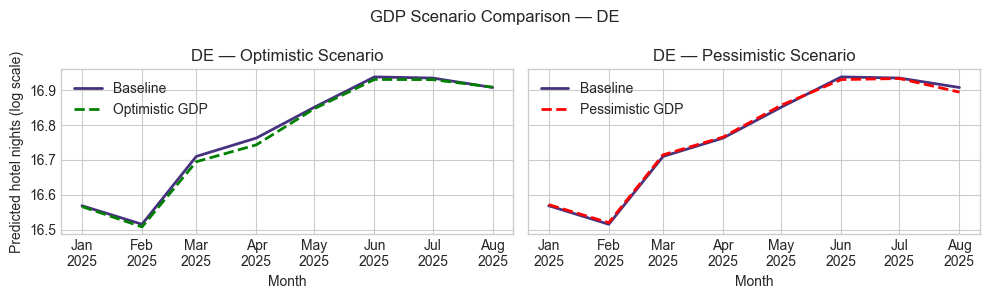

💾 Saved figure for FR → ../outputs/figures/scenario_forecast_comparison_FR.png


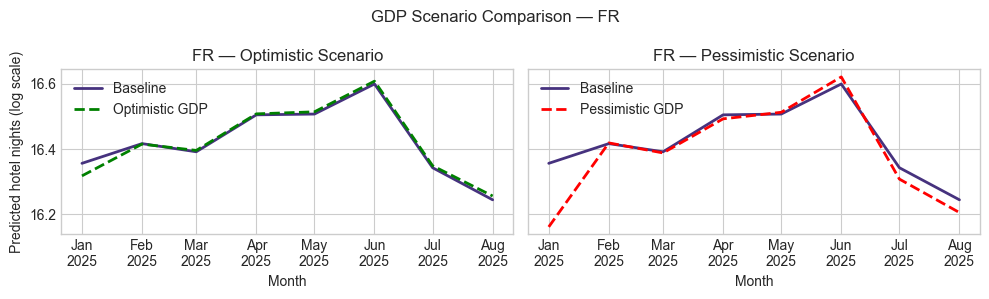

💾 Saved figure for ES → ../outputs/figures/scenario_forecast_comparison_ES.png


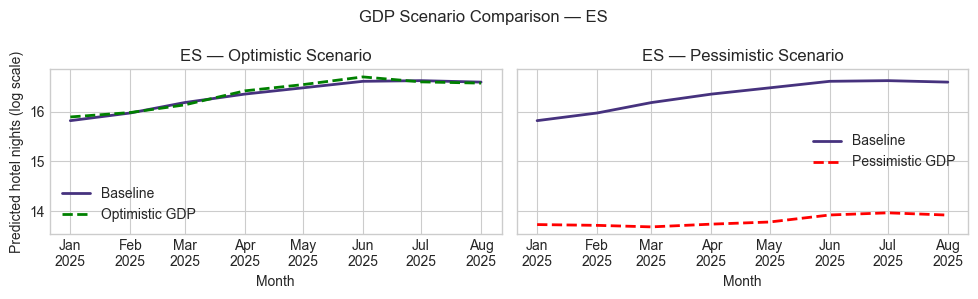

💾 Saved figure for IT → ../outputs/figures/scenario_forecast_comparison_IT.png


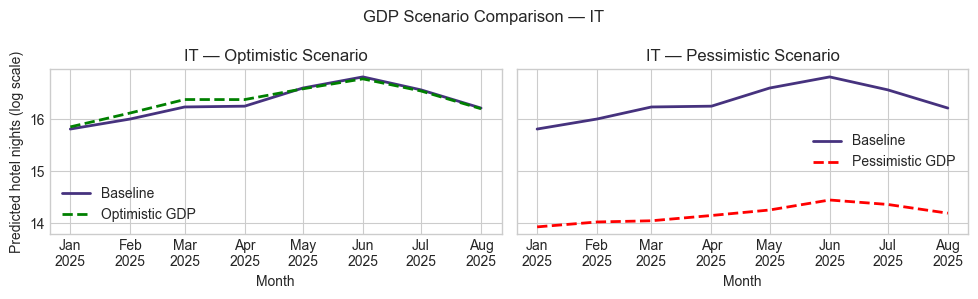

💾 Saved figure for PL → ../outputs/figures/scenario_forecast_comparison_PL.png


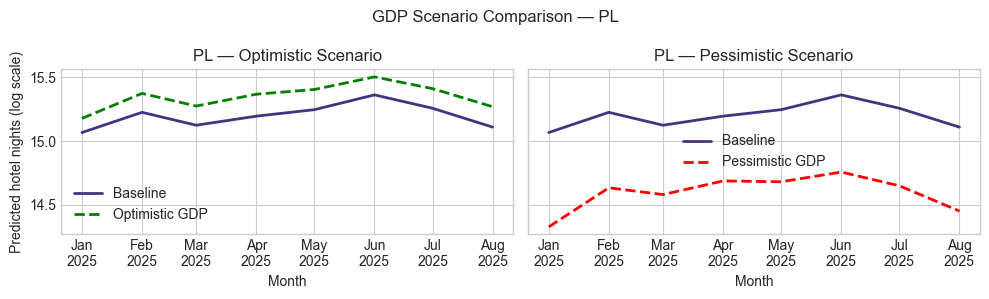

In [6]:
# %% ===============================================================
# STEP 5 — NORMALIZE AND MERGE BASELINE + SCENARIO
# ===============================================================

top_regions = (
    df_plot.groupby("region")["yhat_xgb"]
      .mean().nlargest(5).index.tolist()
)
print("[INFO] Top-5 regions by demand:", top_regions)

plot_gdp_scenarios(
    df_plot,
    countries=top_regions,
    baseline_col="yhat_xgb",
    opt_col="yhat_xgb_optimistic_gdp",
    pes_col="yhat_xgb_pessimistic_gdp",
    save_dir=FIGURES  # ✅ figures automatically saved
)

In [7]:
# %% ===============================================================
# STEP 6 — SCENARIO IMPACT ANALYSIS (% CHANGE)
# ===============================================================

impact_summary = calculate_impact(df_plot)
display(impact_summary.round(2).head(10))

,optimistic_gdp_pct_diff,pessimistic_gdp_pct_diff
region,,
LU,27.77,-2.48
LV,11.95,-1.44
NL,10.72,-1.88
HR,7.47,-3.67
SI,5.70,-3.63
CY,4.61,-4.20
DK,3.89,-0.15
SK,3.42,-3.10
MT,2.73,-5.74


✅ Average GDP Elasticity (approx.):


,region,gdp_elasticity
0,LU,3.024
1,LV,1.339
2,NL,1.260
3,HR,1.113
4,SI,0.933
5,CY,0.881
6,DK,0.404
7,SK,0.652
8,MT,0.847
9,EE,0.529



🔻 Least sensitive:


,region,gdp_elasticity
16,AT,0.276
17,PL,0.495
18,BE,-0.291
19,CZ,0.539
20,IT,1.333
21,ES,1.559
22,FR,0.020
23,DE,-0.004
24,BG,0.998
25,PT,0.089


💾 Saved GDP elasticity chart → ../outputs/figures/gdp_elasticity_by_country.png


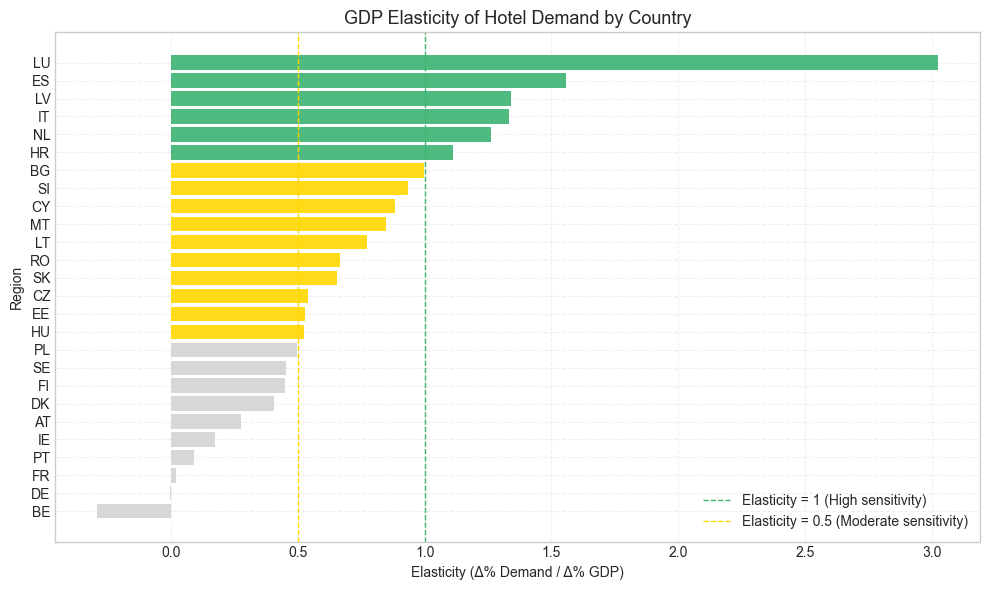

In [8]:
# %% ===============================================================
# STEP 7 — GDP ELASTICITY ANALYSIS
# ===============================================================

# --- Compute GDP elasticity summary
df_sensitivity = calculate_elasticity(impact_summary, shock_size=0.10)

print("✅ Average GDP Elasticity (approx.):")
display(df_sensitivity[["region", "gdp_elasticity"]].round(3).head(10))

print("\n🔻 Least sensitive:")
display(df_sensitivity[["region", "gdp_elasticity"]].round(3).tail(10))

# --- Sort for plotting
df_sensitivity = df_sensitivity.sort_values("gdp_elasticity", ascending=False)

# --- Visualization
plt.figure(figsize=(10, 6))
plt.barh(
    df_sensitivity["region"],
    df_sensitivity["gdp_elasticity"],
    color=df_sensitivity["color"],
    alpha=0.9
)
plt.axvline(1, color="mediumseagreen", linestyle="--", lw=1, label="Elasticity = 1 (High sensitivity)")
plt.axvline(0.5, color="gold", linestyle="--", lw=1, label="Elasticity = 0.5 (Moderate sensitivity)")
plt.gca().invert_yaxis()
plt.title("GDP Elasticity of Hotel Demand by Country", fontsize=13)
plt.xlabel("Elasticity (Δ% Demand / Δ% GDP)")
plt.ylabel("Region")
plt.legend(frameon=False)
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()

# --- Save figure
elasticity_fig_path = FIGURES / "gdp_elasticity_by_country.png"
plt.savefig(elasticity_fig_path, dpi=300, bbox_inches="tight")
print(f"💾 Saved GDP elasticity chart → {elasticity_fig_path}")

plt.show()

In [9]:
# %% ===============================================================
# STEP 8 — SAVE FINAL OUTPUTS
# ===============================================================

print("💾 Saving final scenario outputs...")

# 1️⃣ Save all simulated scenarios
combined = []
for name, df_scen in scenario_outputs.items():
    temp = df_scen.copy()
    temp["scenario"] = name
    combined.append(temp)

df_all_scenarios = pd.concat(combined, ignore_index=True)
df_all_scenarios.to_csv(DATA_PROCESSED / "hotel_scenario_results.csv", index=False)

# 2️⃣ Save merged GDP baseline + scenarios
df_plot.to_csv(DATA_PROCESSED / "hotel_scenario_gdp_merged.csv", index=False)

# 3️⃣ Save elasticity summary
report_dir = BASE_DIR / "outputs" / "reports"
report_dir.mkdir(parents=True, exist_ok=True)
df_sensitivity.to_csv(report_dir / "gdp_elasticity_summary.csv", index=False)

print("✅ All scenario outputs saved successfully:")
print(f"   - Full scenario results → {DATA_PROCESSED / 'hotel_scenario_results.csv'}")
print(f"   - GDP merged view → {DATA_PROCESSED / 'hotel_scenario_gdp_merged.csv'}")
print(f"   - Elasticity summary → {report_dir / 'gdp_elasticity_summary.csv'}")

💾 Saving final scenario outputs...
✅ All scenario outputs saved successfully:
   - Full scenario results → ../data/processed/hotel_scenario_results.csv
   - GDP merged view → ../data/processed/hotel_scenario_gdp_merged.csv
   - Elasticity summary → ../outputs/reports/gdp_elasticity_summary.csv


## ✨ Summary Insight
**Tourism demand in smaller, tourism-driven economies reacts more strongly to GDP changes than in large, diversified ones.**

---

### 🧭 Interpretation — GDP Elasticity of Hotel Demand

The analysis reveals **pronounced cross-country differences** in how hotel demand reacts to changes in economic activity across the EU.  

- **Highly elastic countries** — *Luxembourg (LU), Spain (ES), Latvia (LV), and the Netherlands (NL)* — show an elasticity **greater than 1**, meaning hotel demand expands more than proportionally during economic upswings and contracts faster in downturns.  
  These economies are typically **tourism-intensive and more cyclical**.  

- **Stable markets** — *Germany (DE), France (FR), and Belgium (BE)* — display **low or near-zero elasticity**, reflecting **steady domestic and business-driven travel** that is less sensitive to short-term GDP changes.  

- **Moderately elastic countries** — such as *Slovenia (SI), Cyprus (CY), and Croatia (HR)* — occupy the middle ground, with **moderate responsiveness** to GDP shocks but **structural resilience** in demand.  

Overall, the pattern suggests that **smaller, tourism-reliant economies** experience more pronounced swings in hotel activity in response to macroeconomic fluctuations,  
whereas **larger, diversified economies** remain relatively stable.  

---

*Source: Model-based scenario simulations, forecast horizon January–August 2025.*